# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
!pip install torchsummary
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

# Ghost Batch Normalization

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

## MODEL


In [0]:
def getBatchNorm(type, num_features, num_splits=2):
  if type == 'GBN':
    return GhostBatchNorm(num_features, num_splits)
  else:
    return nn.BatchNorm2d(num_features)

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self, batch_type):
        super(Net, self).__init__()


        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Utils

In [0]:
def getModel(device, batch_type='BN'):
  model = Net(batch_type).to(device)
  return model

def getDevice():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  return device

def getModelSummary(model):
  summary(model, input_size=(1, 28, 28))

In [0]:
def getDataLoader(batchSize):
  BATCH_SIZE = batchSize
  SEED = 1

  # CUDA?
  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
  return dataloader_args

In [0]:
def L1_Loss(model, loss, l1_factor=0.0005):
    # l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
          # zero_vector = torch.rand_like(param) * 0
          reg_loss += torch.sum(param.abs())

    loss += l1_factor * reg_loss
    return loss

In [0]:
def getTrainDataLoader(dataloader_args):
  # Train Phase transformations
  train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) 
                                        ])
  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)

  # train dataloader
  train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
  return train_loader

In [0]:
def getOptimizer(model, lr=0.01, weight_decay=0):
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
  # scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  return optimizer

def train(model, device, train_loader, optimizer, epoch, l1_factor=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_factor:
      loss = L1_Loss(model, loss)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


In [0]:
def getTestDataLoader(dataloader_args):
  # Test Phase transformations
  test_transforms = transforms.Compose([ transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                        ])
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
  return test_loader

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# 8 Methods



In [0]:
def getMisclassifiedImages(batch_type, modelPath):
  model = Net(batch_type)
  model.load_state_dict(torch.load(modelPath))
  model.cuda()
  model.eval()
  misclassifiedImages = []
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)
          target_modified = target.view_as(pred)
          for i in range(len(pred)):
            if pred[i].item()!= target_modified[i].item():
                misclassifiedImages.append([data[i], pred[i], target_modified[i]])

  fig3 = plt.figure(figsize = (15,15))
  for i, im in enumerate(misclassifiedImages[:25]):
      sub = fig3.add_subplot(5, 5, i+1)
      plt.imshow(im[0].cpu().numpy().squeeze(), cmap='gray_r',interpolation='none')
      sub.set_title("Prediction : %s, Actual: %s" % (im[1].data.cpu().numpy()[0], im[2].data.cpu().numpy()[0]))
  plt.tight_layout()
  plt.show()

In [0]:
def saveModel(model, modelPath):
  torch.save(model.state_dict(), modelPath)

In [56]:
!mkdir saved_models

mkdir: cannot create directory ‘saved_models’: File exists


In [13]:
methods = ['BN','GBN','L1_BN','L1_GBN','L2_BN','L2_GBN','L1_L2_BN','L1_L2_GBN']

device = getDevice()
EPOCHS = 25
tot_test_losses = {}
tot_test_acc = {}
tot_train_losses = {}
tot_train_acc = {}
l1_factor = 0
l2_weight_decay = 0
for method in methods:
  print("======================================================================= ", method, " ===============================================================================")
  if method == 'BN' or method == 'L1_BN' or method == 'L2_BN' or method == 'L1_L2_BN':
    BATCH_SIZE = 64
    model =  getModel(device, 'BN')
  if method == 'GBN' or method == 'L1_GBN' or method == 'L2_GBN' or method == 'L1_L2_GBN':
    BATCH_SIZE = 128
    model =  getModel(device, 'GBN')
  if method == 'L1_BN' or method == 'L1_GBN' or method == 'L1_L2_BN' or method == 'L1_L2_GBN':
    l1_factor = 0.0005
  else:
    l1_factor = 0
  if method == 'L2_BN' or method == 'L2_GBN' or method == 'L1_L2_BN' or method == 'L1_L2_GBN':
    l2_weight_decay = 0.0005
  else:
    l2_weight_decay = 0

  getModelSummary(model)
  optimizer = getOptimizer(model, 0.01, l2_weight_decay)
  dataLoaderArgs = getDataLoader(BATCH_SIZE)
  train_loader = getTrainDataLoader(dataLoaderArgs)
  test_loader = getTestDataLoader(dataLoaderArgs)
  test_losses = []
  test_acc = []
  train_losses = []
  train_acc = []
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, l1_factor)
      test(model, device, test_loader)
  tot_test_losses[method] = test_losses
  tot_test_acc[method] = test_acc
  tot_train_losses[method] = train_losses
  tot_train_acc[method] = train_acc
  saveModel(model, 'saved_models/'+method+'.pt')

=======================================================================  BN  ===============================================================================


  0%|          | 0/938 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        MaxPool2d-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1, 16,

Loss=0.2327280193567276 Batch_id=937 Accuracy=91.84: 100%|██████████| 938/938 [00:16<00:00, 56.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0729, Accuracy: 9770/10000 (97.70%)

EPOCH: 1


Loss=0.011079758405685425 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:17<00:00, 55.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.02602332830429077 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:16<00:00, 56.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.02897455543279648 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [00:16<00:00, 56.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.033877670764923096 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:16<00:00, 56.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.0404457151889801 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:16<00:00, 55.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.11547978222370148 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:16<00:00, 56.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.07692810893058777 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:16<00:00, 57.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.06761430203914642 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:16<00:00, 56.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.017247796058654785 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:16<00:00, 56.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.01663370430469513 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:16<00:00, 56.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.006856948137283325 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:16<00:00, 56.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


Loss=0.005054056644439697 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:17<00:00, 54.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.19131587445735931 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 54.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.05268700420856476 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:17<00:00, 54.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.004498720169067383 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:16<00:00, 55.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.0337674617767334 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:16<00:00, 56.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.005081683397293091 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:16<00:00, 56.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.04125375300645828 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:16<00:00, 55.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.013330668210983276 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:16<00:00, 56.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.038013532757759094 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:16<00:00, 56.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.0028149038553237915 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:16<00:00, 56.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.0047814249992370605 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:16<00:00, 55.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.003258049488067627 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:16<00:00, 56.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.04374806582927704 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:16<00:00, 55.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)

=======================================================================  GBN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
    GhostBatchNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        M

Loss=0.1835535168647766 Batch_id=468 Accuracy=87.81: 100%|██████████| 469/469 [00:13<00:00, 35.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0847, Accuracy: 9778/10000 (97.78%)

EPOCH: 1


Loss=0.18146230280399323 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.07753513008356094 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


Loss=0.08007556945085526 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.02492324449121952 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.05665242671966553 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.020214596763253212 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.045201826840639114 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.007977436296641827 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.02824634127318859 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.009534190408885479 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.06390558928251266 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.01927213929593563 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.07729021459817886 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.05285918712615967 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.020657533779740334 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9949/10000 (99.49%)

EPOCH: 16


Loss=0.058049459010362625 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 34.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


Loss=0.09760591387748718 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.053566742688417435 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 34.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.03278060629963875 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.01303484570235014 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)

EPOCH: 21


Loss=0.06236787140369415 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


Loss=0.014083738438785076 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 36.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Loss=0.05776044726371765 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9945/10000 (99.45%)

EPOCH: 24


Loss=0.013598263263702393 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9944/10000 (99.44%)

=======================================================================  L1_BN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
       

Loss=0.3815799355506897 Batch_id=937 Accuracy=91.58: 100%|██████████| 938/938 [00:18<00:00, 49.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0989, Accuracy: 9681/10000 (96.81%)

EPOCH: 1


Loss=0.3298376798629761 Batch_id=937 Accuracy=96.98: 100%|██████████| 938/938 [00:19<00:00, 47.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0648, Accuracy: 9798/10000 (97.98%)

EPOCH: 2


Loss=0.31929445266723633 Batch_id=937 Accuracy=97.37: 100%|██████████| 938/938 [00:19<00:00, 47.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.2230796217918396 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:19<00:00, 48.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9864/10000 (98.64%)

EPOCH: 4


Loss=0.24343076348304749 Batch_id=937 Accuracy=97.47: 100%|██████████| 938/938 [00:19<00:00, 48.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9864/10000 (98.64%)

EPOCH: 5


Loss=0.24854214489459991 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:18<00:00, 49.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9881/10000 (98.81%)

EPOCH: 6


Loss=0.24949011206626892 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:19<00:00, 48.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0688, Accuracy: 9794/10000 (97.94%)

EPOCH: 7


Loss=0.3339990973472595 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:19<00:00, 49.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9855/10000 (98.55%)

EPOCH: 8


Loss=0.2094976007938385 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:18<00:00, 49.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9863/10000 (98.63%)

EPOCH: 9


Loss=0.21240216493606567 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:18<00:00, 50.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9885/10000 (98.85%)

EPOCH: 10


Loss=0.20666801929473877 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:19<00:00, 49.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9820/10000 (98.20%)

EPOCH: 11


Loss=0.3219521641731262 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:18<00:00, 50.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9858/10000 (98.58%)

EPOCH: 12


Loss=0.2975219190120697 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:19<00:00, 49.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9844/10000 (98.44%)

EPOCH: 13


Loss=0.3764348328113556 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:18<00:00, 50.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9819/10000 (98.19%)

EPOCH: 14


Loss=0.34470924735069275 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:18<00:00, 51.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9865/10000 (98.65%)

EPOCH: 15


Loss=0.19789022207260132 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:19<00:00, 49.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9867/10000 (98.67%)

EPOCH: 16


Loss=0.19755658507347107 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:18<00:00, 50.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9880/10000 (98.80%)

EPOCH: 17


Loss=0.2694271206855774 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:18<00:00, 50.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9823/10000 (98.23%)

EPOCH: 18


Loss=0.2897031903266907 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:18<00:00, 50.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9853/10000 (98.53%)

EPOCH: 19


Loss=0.1808501034975052 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:18<00:00, 51.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9882/10000 (98.82%)

EPOCH: 20


Loss=0.2733762264251709 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:18<00:00, 51.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9894/10000 (98.94%)

EPOCH: 21


Loss=0.33991312980651855 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:18<00:00, 51.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9838/10000 (98.38%)

EPOCH: 22


Loss=0.22205667197704315 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:18<00:00, 51.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9871/10000 (98.71%)

EPOCH: 23


Loss=0.20100538432598114 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:18<00:00, 51.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9843/10000 (98.43%)

EPOCH: 24


Loss=0.22468838095664978 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:18<00:00, 51.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9854/10000 (98.54%)

=======================================================================  L1_GBN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
    GhostBatchNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
      

Loss=0.4595150053501129 Batch_id=468 Accuracy=87.93: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0994, Accuracy: 9737/10000 (97.37%)

EPOCH: 1


Loss=0.4091199040412903 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0716, Accuracy: 9795/10000 (97.95%)

EPOCH: 2


Loss=0.2555687427520752 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0653, Accuracy: 9800/10000 (98.00%)

EPOCH: 3


Loss=0.25588124990463257 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9869/10000 (98.69%)

EPOCH: 4


Loss=0.2493724822998047 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.2203274965286255 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9875/10000 (98.75%)

EPOCH: 6


Loss=0.2551037669181824 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9790/10000 (97.90%)

EPOCH: 7


Loss=0.23647677898406982 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9871/10000 (98.71%)

EPOCH: 8


Loss=0.19060784578323364 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.3065693974494934 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9863/10000 (98.63%)

EPOCH: 10


Loss=0.18511219322681427 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9866/10000 (98.66%)

EPOCH: 11


Loss=0.26295170187950134 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9866/10000 (98.66%)

EPOCH: 12


Loss=0.19030947983264923 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9867/10000 (98.67%)

EPOCH: 13


Loss=0.32327234745025635 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9856/10000 (98.56%)

EPOCH: 14


Loss=0.25834208726882935 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9900/10000 (99.00%)

EPOCH: 15


Loss=0.19218337535858154 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9853/10000 (98.53%)

EPOCH: 16


Loss=0.27071815729141235 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9873/10000 (98.73%)

EPOCH: 17


Loss=0.2668824791908264 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:14<00:00, 33.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9863/10000 (98.63%)

EPOCH: 18


Loss=0.23318974673748016 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9870/10000 (98.70%)

EPOCH: 19


Loss=0.19317235052585602 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9880/10000 (98.80%)

EPOCH: 20


Loss=0.23294603824615479 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9879/10000 (98.79%)

EPOCH: 21


Loss=0.28872817754745483 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:13<00:00, 34.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9846/10000 (98.46%)

EPOCH: 22


Loss=0.21665149927139282 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9870/10000 (98.70%)

EPOCH: 23


Loss=0.2588983178138733 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9870/10000 (98.70%)

EPOCH: 24


Loss=0.19639360904693604 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9881/10000 (98.81%)

=======================================================================  L2_BN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
       

Loss=0.14943382143974304 Batch_id=937 Accuracy=91.64: 100%|██████████| 938/938 [00:16<00:00, 57.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9840/10000 (98.40%)

EPOCH: 1


Loss=0.07207846641540527 Batch_id=937 Accuracy=97.39: 100%|██████████| 938/938 [00:16<00:00, 56.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.11624216288328171 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:16<00:00, 56.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.03420713543891907 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:16<00:00, 57.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.09988123178482056 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [00:16<00:00, 56.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.09540946781635284 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:16<00:00, 57.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.13482210040092468 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:16<00:00, 56.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.04640667885541916 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:16<00:00, 57.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.059103332459926605 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:16<00:00, 57.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.06700341403484344 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:16<00:00, 57.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.010460108518600464 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:16<00:00, 57.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


Loss=0.05522827059030533 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:16<00:00, 57.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.09213590621948242 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:16<00:00, 57.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.20856088399887085 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:16<00:00, 57.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.08945357799530029 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:16<00:00, 57.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9923/10000 (99.23%)

EPOCH: 15


Loss=0.007090240716934204 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:16<00:00, 56.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.08857578039169312 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:16<00:00, 57.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.007137298583984375 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:16<00:00, 57.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.03090791404247284 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:16<00:00, 57.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.036372244358062744 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:16<00:00, 57.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.10269901156425476 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:16<00:00, 57.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.00981438159942627 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:16<00:00, 56.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.052231527864933014 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:16<00:00, 57.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.01592610776424408 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:16<00:00, 57.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 24


Loss=0.008666396141052246 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:16<00:00, 56.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9906/10000 (99.06%)

=======================================================================  L2_GBN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
    GhostBatchNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
      

Loss=0.1981561928987503 Batch_id=468 Accuracy=87.77: 100%|██████████| 469/469 [00:12<00:00, 36.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0871, Accuracy: 9769/10000 (97.69%)

EPOCH: 1


Loss=0.16399365663528442 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:12<00:00, 36.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.0713195949792862 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:12<00:00, 36.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.07289247959852219 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:13<00:00, 35.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.031883399933576584 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:13<00:00, 35.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.038142815232276917 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:12<00:00, 36.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.014536231756210327 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.041049543768167496 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:12<00:00, 36.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.01500046718865633 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.05342837795615196 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:12<00:00, 36.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.014746904373168945 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 35.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.047252852469682693 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 35.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.02336757630109787 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:12<00:00, 36.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.08669041842222214 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.04162709042429924 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.03400905802845955 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 35.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.06906577199697495 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:12<00:00, 36.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.06749080866575241 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.05376672372221947 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 36.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.043869499117136 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.01641041599214077 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.031136134639382362 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 35.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.028438439592719078 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 36.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.037442225962877274 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.03244423866271973 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:12<00:00, 36.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

=======================================================================  L1_L2_BN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
    

Loss=0.3331336975097656 Batch_id=937 Accuracy=91.51: 100%|██████████| 938/938 [00:18<00:00, 51.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0784, Accuracy: 9773/10000 (97.73%)

EPOCH: 1


Loss=0.3843754529953003 Batch_id=937 Accuracy=97.03: 100%|██████████| 938/938 [00:18<00:00, 50.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0862, Accuracy: 9724/10000 (97.24%)

EPOCH: 2


Loss=0.2736230492591858 Batch_id=937 Accuracy=97.38: 100%|██████████| 938/938 [00:18<00:00, 50.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.23275598883628845 Batch_id=937 Accuracy=97.33: 100%|██████████| 938/938 [00:18<00:00, 50.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9851/10000 (98.51%)

EPOCH: 4


Loss=0.23568934202194214 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:18<00:00, 49.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9873/10000 (98.73%)

EPOCH: 5


Loss=0.23871901631355286 Batch_id=937 Accuracy=97.46: 100%|██████████| 938/938 [00:19<00:00, 49.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0649, Accuracy: 9816/10000 (98.16%)

EPOCH: 6


Loss=0.32130205631256104 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [00:19<00:00, 49.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9822/10000 (98.22%)

EPOCH: 7


Loss=0.2596580684185028 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:19<00:00, 48.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9826/10000 (98.26%)

EPOCH: 8


Loss=0.278833270072937 Batch_id=937 Accuracy=97.43: 100%|██████████| 938/938 [00:19<00:00, 49.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9836/10000 (98.36%)

EPOCH: 9


Loss=0.2978265881538391 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:18<00:00, 49.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0725, Accuracy: 9776/10000 (97.76%)

EPOCH: 10


Loss=0.21406897902488708 Batch_id=937 Accuracy=97.43: 100%|██████████| 938/938 [00:18<00:00, 49.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9832/10000 (98.32%)

EPOCH: 11


Loss=0.24500411748886108 Batch_id=937 Accuracy=97.44: 100%|██████████| 938/938 [00:18<00:00, 50.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9856/10000 (98.56%)

EPOCH: 12


Loss=0.3842482268810272 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:18<00:00, 50.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9835/10000 (98.35%)

EPOCH: 13


Loss=0.40308237075805664 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:18<00:00, 50.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0795, Accuracy: 9741/10000 (97.41%)

EPOCH: 14


Loss=0.23433980345726013 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:18<00:00, 49.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9831/10000 (98.31%)

EPOCH: 15


Loss=0.16828013956546783 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:18<00:00, 50.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9803/10000 (98.03%)

EPOCH: 16


Loss=0.19555850327014923 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [00:18<00:00, 49.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9860/10000 (98.60%)

EPOCH: 17


Loss=0.25379014015197754 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:18<00:00, 50.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9767/10000 (97.67%)

EPOCH: 18


Loss=0.2278844714164734 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:18<00:00, 49.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9869/10000 (98.69%)

EPOCH: 19


Loss=0.25869452953338623 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:18<00:00, 49.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9844/10000 (98.44%)

EPOCH: 20


Loss=0.353304386138916 Batch_id=937 Accuracy=97.47: 100%|██████████| 938/938 [00:18<00:00, 49.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9832/10000 (98.32%)

EPOCH: 21


Loss=0.22761961817741394 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [00:19<00:00, 48.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9876/10000 (98.76%)

EPOCH: 22


Loss=0.23734287917613983 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:18<00:00, 49.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9845/10000 (98.45%)

EPOCH: 23


Loss=0.20413585007190704 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:18<00:00, 50.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9801/10000 (98.01%)

EPOCH: 24


Loss=0.24713265895843506 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:19<00:00, 49.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9874/10000 (98.74%)

=======================================================================  L1_L2_GBN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
    GhostBatchNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
   

Loss=0.4251897931098938 Batch_id=468 Accuracy=87.92: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0877, Accuracy: 9768/10000 (97.68%)

EPOCH: 1


Loss=0.45316100120544434 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0689, Accuracy: 9804/10000 (98.04%)

EPOCH: 2


Loss=0.2536637783050537 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0716, Accuracy: 9796/10000 (97.96%)

EPOCH: 3


Loss=0.26149606704711914 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.24557343125343323 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9863/10000 (98.63%)

EPOCH: 5


Loss=0.201288640499115 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9871/10000 (98.71%)

EPOCH: 6


Loss=0.21262863278388977 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9840/10000 (98.40%)

EPOCH: 7


Loss=0.23594114184379578 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9866/10000 (98.66%)

EPOCH: 8


Loss=0.20277203619480133 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9817/10000 (98.17%)

EPOCH: 9


Loss=0.27393415570259094 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9814/10000 (98.14%)

EPOCH: 10


Loss=0.1896609663963318 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0705, Accuracy: 9795/10000 (97.95%)

EPOCH: 11


Loss=0.2515203654766083 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9863/10000 (98.63%)

EPOCH: 12


Loss=0.22028732299804688 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9872/10000 (98.72%)

EPOCH: 13


Loss=0.27884912490844727 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0905, Accuracy: 9724/10000 (97.24%)

EPOCH: 14


Loss=0.23959442973136902 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9892/10000 (98.92%)

EPOCH: 15


Loss=0.1653083860874176 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9895/10000 (98.95%)

EPOCH: 16


Loss=0.258181095123291 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9896/10000 (98.96%)

EPOCH: 17


Loss=0.212647944688797 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9875/10000 (98.75%)

EPOCH: 18


Loss=0.23020273447036743 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9880/10000 (98.80%)

EPOCH: 19


Loss=0.19890637695789337 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9887/10000 (98.87%)

EPOCH: 20


Loss=0.1726330667734146 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9876/10000 (98.76%)

EPOCH: 21


Loss=0.2661811113357544 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9873/10000 (98.73%)

EPOCH: 22


Loss=0.21524927020072937 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9853/10000 (98.53%)

EPOCH: 23


Loss=0.2387700378894806 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9816/10000 (98.16%)

EPOCH: 24


Loss=0.19305959343910217 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]



Test set: Average loss: 0.0543, Accuracy: 9836/10000 (98.36%)



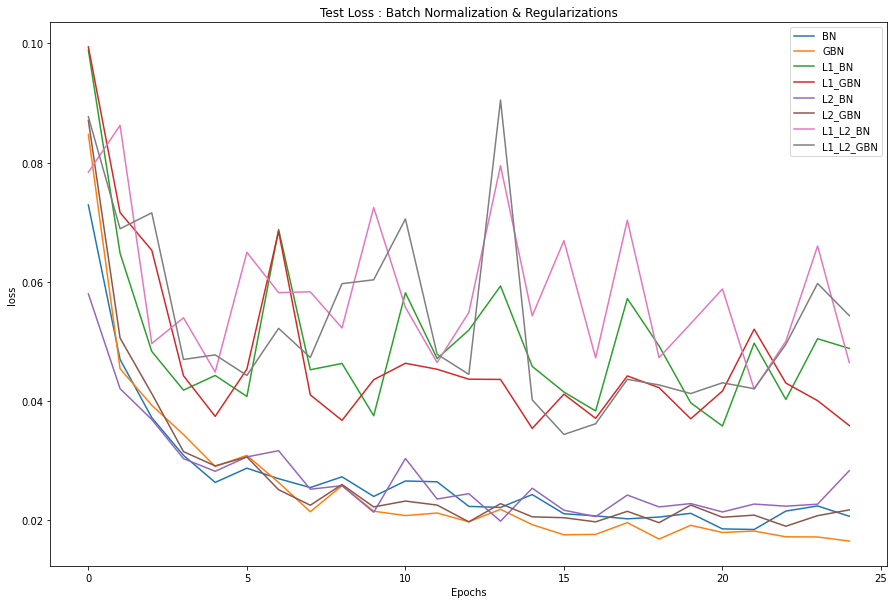

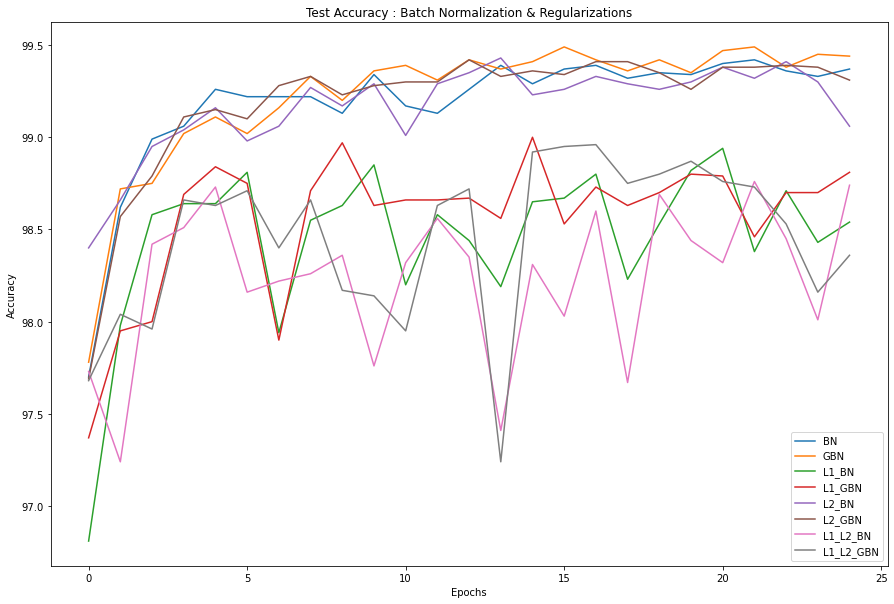

In [14]:
import pandas as pd
testing_all_loss = pd.DataFrame(tot_test_losses)
testing_all_accuracy = pd.DataFrame(tot_test_acc)

fig1 = testing_all_loss.plot(figsize=(15,10), kind = 'line', title = "Test Loss : Batch Normalization & Regularizations")
fig1.set_xlabel("Epochs")
fig1.set_ylabel("loss")

fig2 = testing_all_accuracy.plot(figsize=(15,10), kind = 'line', title = "Test Accuracy : Batch Normalization & Regularizations")
fig2.set_xlabel("Epochs")
fig2.set_ylabel("Accuracy")

fig1
fig2

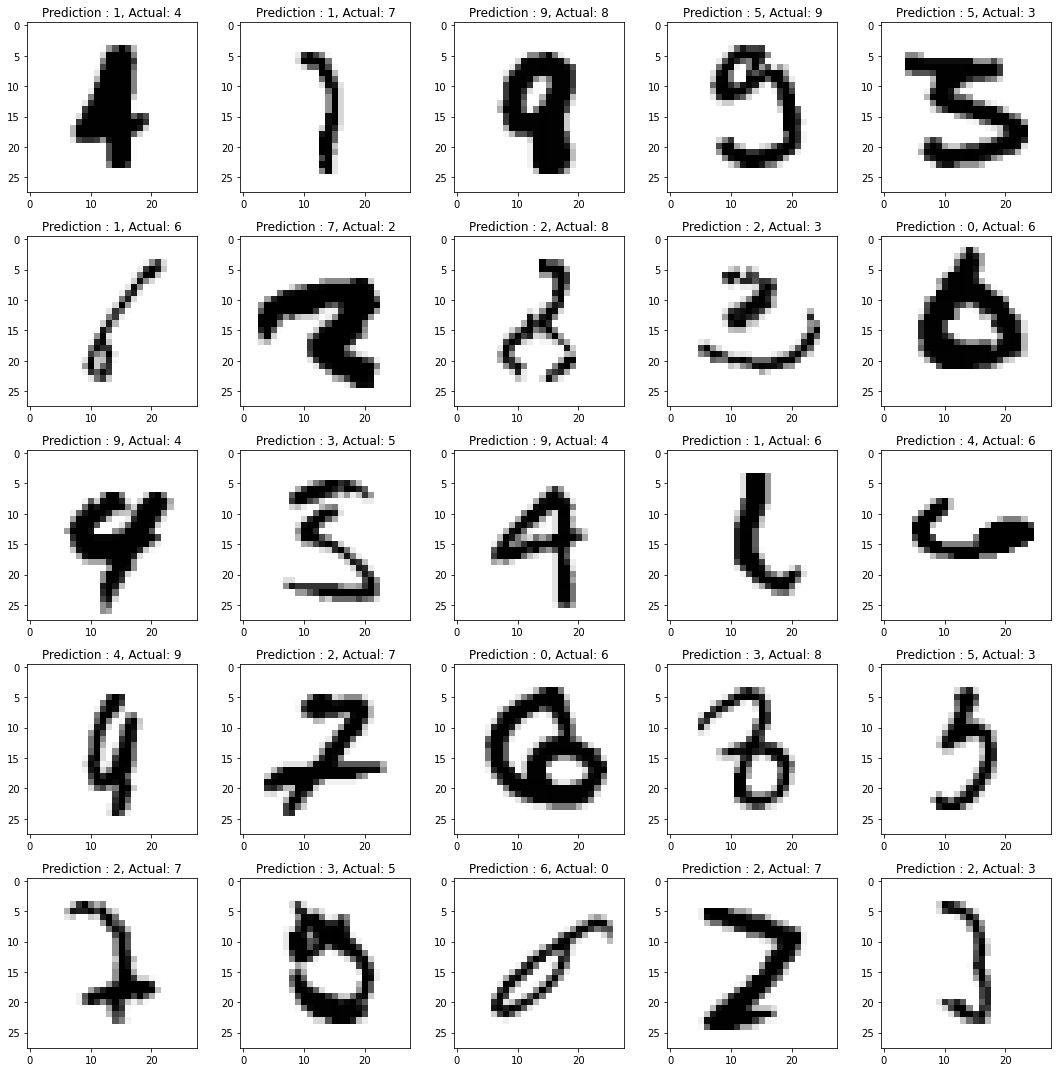

In [16]:
getMisclassifiedImages('BN', 'saved_models/BN.pt')

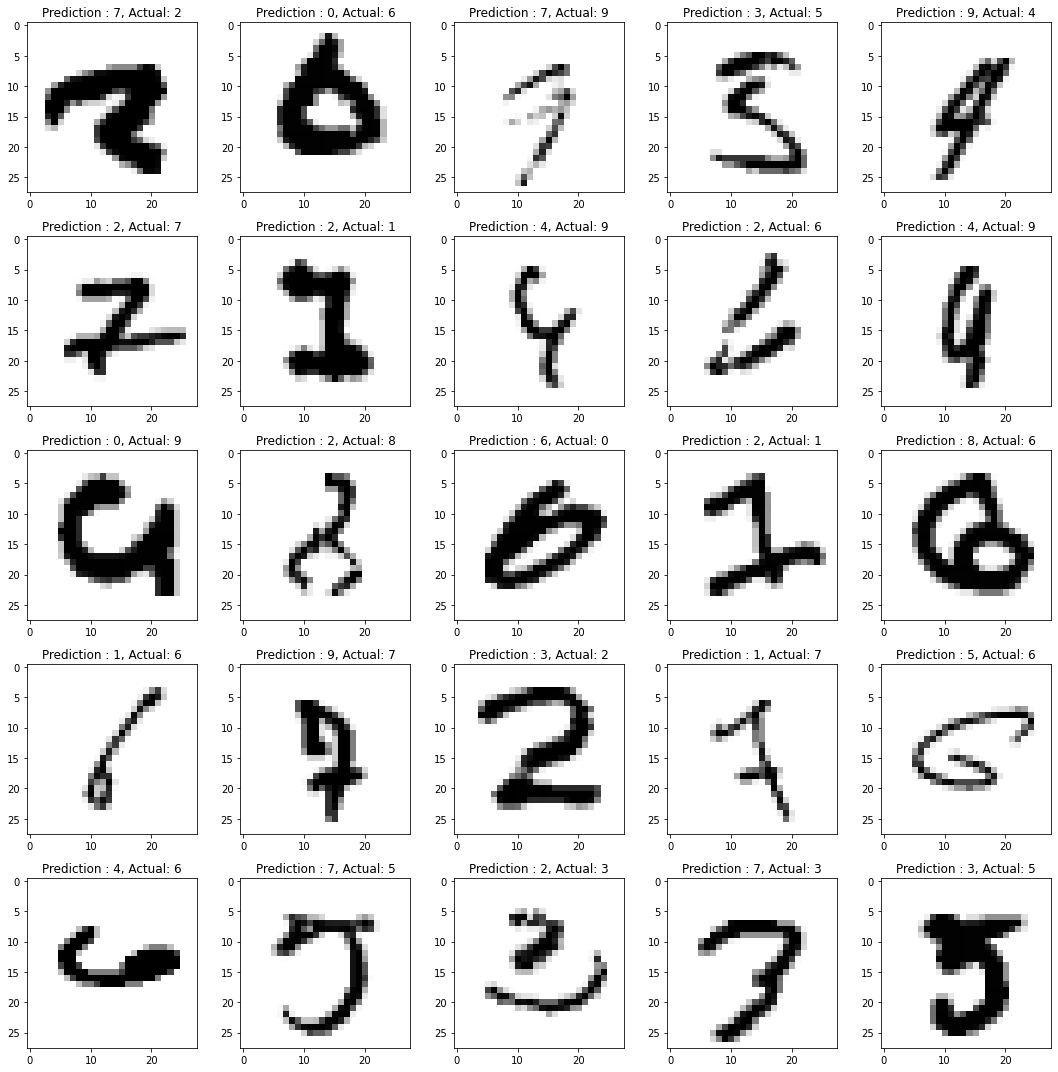

In [17]:
getMisclassifiedImages('GBN','saved_models/GBN.pt')